# Réseau de neurones et Causalité

Nous allons essayer d'appliquer les algorithmes de génération de cause à un réseau de neurones.

## Réseau de neurones

In [1]:
#réseau de neuronne pouvant résoudre un problème de classification sur 2 classes:
#une classe étant l'ensemble des point sur la boule unité
#l'autre étant un ensemble de point décalé par un bruit du cerce de rayon 2 centré en 0

import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

from main import *

def generedata(N=10000,propc1=0.5,seed = 42):
    mu, sigma = 2, 0.1
    res = []
    label = []
    np.random.seed(seed)
    while len(res)<N:
        if np.random.rand() < propc1: #classe 1 boule unité + caré privé de boule de rayon 3
            label.append(0)
            if np.random.rand() < 0.2 :#boule unité
                tmp = 2*np.random.rand(2) - 1
                while np.linalg.norm(tmp,ord =2) > mu -1:
                    tmp = 2 * np.random.rand(2) - 1
                res.append(tmp)
            else:# carré privé de boule de rayon 3
                tmp = 2*np.random.rand(2) - 1
                while np.linalg.norm(tmp,ord =2) < mu +1:
                    tmp = (2 * np.random.rand(2) - 1) * 4
                res.append(tmp)
        else: #classe 0 cercle bruité de rayon 2
            label.append(1)
            r =  np.random.normal(mu, sigma)
            theta = 2*np.pi * np.random.rand()
            res.append(np.array([r*np.cos(theta),r*np.sin(theta)]))
    return np.array(res),np.array(label)

def scoring(Y_pred,Y_test):
    n = Y_pred.size
    cpt = 0
    for i in range(n):
        if Y_pred[i] == Y_test[i]:
            cpt += 1
    return 100*cpt/n




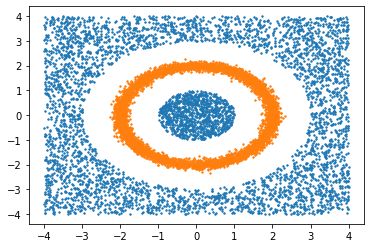

In [2]:
s = 5687
X_train,Y_train = generedata(seed = s)
plt.scatter(X_train[np.where(Y_train ==0)][:,0],X_train[np.where(Y_train ==0)][:,1],s=2)
plt.scatter(X_train[np.where(Y_train ==1)][:,0],X_train[np.where(Y_train ==1)][:,1],s=2)

Le réseau de neurone que l'on va considérer devra classer classer des points entre les 2 classes bleue (0) et orange (1).
La classe orange est un cercle bruité d'un certain rayon.

### Apprentissage du NN

On utilise ```sklearn``` pour l'implémentation du réseau de neurone. <br>
On utilise un Perceptron multi-couche pour cet exemple. <br>
On génére les données et on initialise le réseau de neurone avec ces seeds car on va discrétiser les valeurs d'activations de chaque neurones. <br>
Ces valeurs ont été choisies pour avoir un taux de bonne classification supérieur à 99% même avec discrétisation.

In [115]:
sg = 986117
MLP = MLPClassifier(activation='tanh',random_state = sg,hidden_layer_sizes = (4,2),alpha = 0.1, max_iter = 1000) #4 couches, 2 cachées, une output binaire
MLP.fit(X_train, Y_train)

for s in [10,53135,38,52,64]: #vérification
    X_test,Y_test = generedata(N = 2000,seed = s)
    Y_pred = MLP.predict(X_test)### Simulation de l'inférence du NN
    print(scoring(Y_pred,Y_test))

100.0
100.0
100.0
100.0
100.0


In [4]:
np.linspace(-1,1,6)

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

### Simulation de l'inférence du NN

Ces fonction permettent de vérifier qu'a partir des coefficients donnés par ```sklearn``` on arrive à des bons résultats même en discrétisant (on cast les valeurs d'activations des neurones en nombre entier).  

In [13]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig


def discretize(X,l=np.linspace(-1,1,6)):
    return min(l, key=lambda x:abs(x-X))

def f1d(u,w,b): #simule le passage de l'input a la premiere couche cachee
    res = u @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = discretize(np.tanh(res[i]))
    return res

def f2d(v,w,b): #simule le passage de la premiere couche cachee a la seconde
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = discretize(np.tanh(res[i]))
    return res

def f3d(v,w,b): #simule le passage de la premiere couche cachee a la seconde
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = sigmoid(res[i])>0.5
    return res


def my_NNd(inp,w0,w1,w2,b0,b1,b2): #simule le reseau de neurone complet "discretisé"
    pred = []             
    for u in inp:
        v0 = f1d(u,w0,b0) 
        v1 = f2d(v0,w1,b1)
        v2 = f3d(v1,w2,b2)
        pred.append(v2[0])
    return pred

In [14]:
w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]

b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]

for s in [38541351,351,61868,98465,35743]:
    X_test,Y_test = generedata(N = 20000,seed = s)
    Y_pred = np.array(my_NNd(X_test,w0,w1,w2,b0,b1,b2))
    print(scoring(Y_pred,Y_test))

97.745
97.675
97.48
97.705
97.765


On voit qu'avec des seeds quelconques, on arrive a un bon taux de classification même avec la discrétisation.

Cette fonction simule le réseau de neurone sans discretisation et retourne la prédiction et la valeur d'activation des neurones de la seconde couche cachée.

In [116]:
def f1(u,w,b): #simule le passage de l'input a la premiere couche cachee
    res = u @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = np.tanh(res[i])
    return res

def f2(v,w,b): #simule le passage de la premiere couche cachee a la seconde
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = np.tanh(res[i])
    return res

def f3(v,w,b): #simule le passage de la premiere couche cachee a la seconde
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = sigmoid(res[i])
    return res


def my_NN(inp,w0,w1,w2,b0,b1,b2): #simule le reseau de neurone complet
    pred = []    
    neuron_act = []
    for u in inp:
        v0 = f1(u,w0,b0) 
        v1 = f2(v0,w1,b1)
        v2 = f3(v1,w2,b2)
        pred.append(v2[0])
        neuron_act.append(v1)
    return pred,neuron_act

## Comment interpréter les fonctions des différentes couches ?
### Première couche

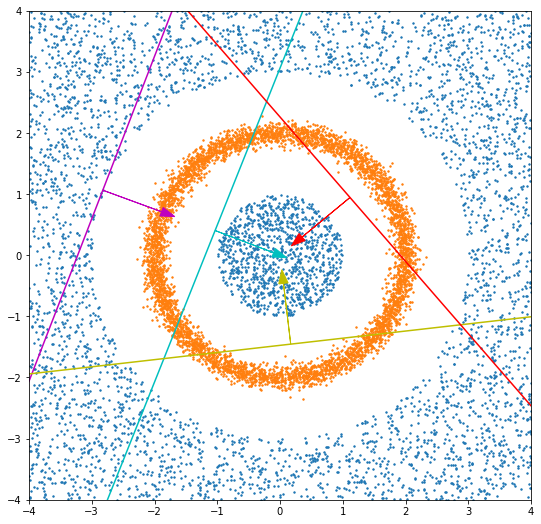

986117


In [11]:
w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]

b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]

L = 4
plt_1 = plt.figure(figsize=(9, 9))
plt.scatter(X_train[np.where(Y_train ==0)][:,0],X_train[np.where(Y_train ==0)][:,1],s=2)
plt.scatter(X_train[np.where(Y_train ==1)][:,0],X_train[np.where(Y_train ==1)][:,1],s=2)
#ligne 1
X = [-L,L]
y1 = [(-w0[0][0]*x-b0[0])/w0[1][0] for x in X]
xi = (b0[0]/w0[1][0])/((-w0[0][0])/w0[1][0] - (w0[1][0])/w0[0][0])
yi = (w0[1][0])/w0[0][0] * xi
a = w0[0][0]/np.sqrt(w0[0][0]**2 + w0[1][0]**2)
b = w0[1][0]/np.sqrt(w0[0][0]**2 + w0[1][0]**2)
plt.arrow(xi, yi, a, b, head_width=0.15, color = 'c')

#ligne 2
y2 = [(-w0[0][1]*x-b0[1])/w0[1][1] for x in X]
xi = (b0[1]/w0[1][1])/((-w0[0][1])/w0[1][1] - (w0[1][1])/w0[0][1])
yi = (w0[1][1])/w0[0][1] * xi
a = w0[0][1]/np.sqrt(w0[0][1]**2 + w0[1][1]**2)
b = w0[1][1]/np.sqrt(w0[0][1]**2 + w0[1][1]**2)
plt.arrow(xi, yi, a, b, head_width=0.15, color = 'm')

#ligne 3
y3 = [(-w0[0][2]*x-b0[2])/w0[1][2] for x in X]
xi = (b0[2]/w0[1][2])/((-w0[0][2])/w0[1][2] - (w0[1][2])/w0[0][2])
yi = (w0[1][2])/w0[0][2] * xi
a = w0[0][2]/np.sqrt(w0[0][2]**2 + w0[1][2]**2)
b = w0[1][2]/np.sqrt(w0[0][2]**2 + w0[1][2]**2)
plt.arrow(xi, yi, a, b, head_width=0.15, color = 'y')

#ligne 4
y4 = [(-w0[0][3]*x-b0[3])/w0[1][3] for x in X]
xi = (b0[3]/w0[1][3])/((-w0[0][3])/w0[1][3] - (w0[1][3])/w0[0][3])
yi = (w0[1][3])/w0[0][3] * xi
a = w0[0][3]/np.sqrt(w0[0][3]**2 + w0[1][3]**2)
b = w0[1][3]/np.sqrt(w0[0][3]**2 + w0[1][3]**2)
plt.arrow(xi, yi, a, b, head_width=0.15, color = 'r')

plt.plot(X,y1,'c',X,y2,'m',X,y3,'y',X,y4,'r')


plt.xlim([-L, L])
plt.ylim([-L, L])
plt.show()
plt.close()

print(sg)

La première couche permet d'extraire d'avantages d'information des différents points. <br>
On remarque que les frontières de décision forment des triangles autour de la boule de rayon 1.
Une telle configuration sert à délimiter deux zones dans le plan. 

### Couches profondes

In [102]:
xgrid = np.linspace(-L,L,101)
ygrid = np.linspace(-L,L,101)
XX,YY = np.meshgrid(xgrid,ygrid)
p,z = my_NN(grid,w0,w1,w2,b0,b1,b2)
p = np.array(p)
z = np.array(z)

Pour interpréter les couches suivantes on va tracer la carte topographique des valeurs d'activation des neurones des couches profondes.

### Deuxième couche cachée

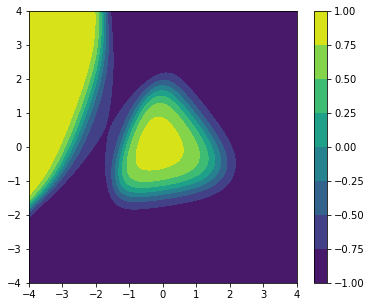

In [119]:
plt.figure(figsize=(6, 5))
plt.contourf(XX,YY, z[:,0].reshape((101,101)))
plt.colorbar()
plt.show()
plt.close()

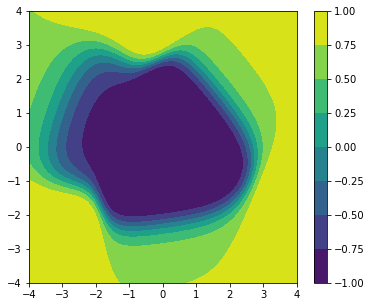

In [120]:
plt.figure(figsize=(6, 5))
plt.contourf(XX,YY, z[:,1].reshape((101,101)))
plt.colorbar()
plt.show()
plt.close()

On remarque que la valeur d'activations des deux neurones de cette couche correspondes a deux zones. Pour la première, on reconnait les points de la boule centrale, et pour la deuxième, il s'agit des point à l'extérieur du cercle. <br>
Pour être classé positivement (appartenant au cercle bruité), il faut donc ne pas être dans les zones jaunes pour les 2 neurones c'est à dire être dans les deux zones bleues.

### Dernière couche

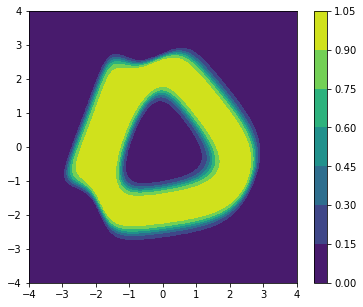

In [121]:
plt.figure(figsize=(6, 5))
plt.contourf(XX,YY, p.reshape((101,101)))
plt.colorbar()
plt.show()
plt.close()

On reconnait ici ce qui a été évoqué précédemment.<br>
La fontière de décision correspond a n'appartenir à aucunes des zones jaunes de la couche précédente.

## Causalité

Le graphe causal correspondant au réseau de neurone précédent construit ci-dessous. <br><br>
Les variable exogènes sont donc l'entrée du réseau de neurone. <br><br>
Les variables endogènes correspondent aux différents scores évoqués précédemment :<br>
Les ```v0_```correspondent aux 3 scores de la première couche cachée.<br>
Les ```v1_```correspondent aux 2 scores de la deuxièmes couche cachée.<br>
La variable ```output```correspond à la sortie/prédiction du réseau de neurone.

In [126]:
#Coordonnées dans le plan
U = {'u0': [-3+i*0.06 for i in range(101)],\
    'u1':[-3+i*0.06 for i in range(101)]} 
#Valeur d'activation
V = {'v00' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
     'v01' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],\
     'v02' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],\
     'v03' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],\
     
     'v10' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
     'v11' : [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],\
     
     'output' : [0,1]}

w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]

b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]


def compute_v00(param):
    u0 = param['u0']
    u1 = param['u1']
    return discretize(np.tanh((np.array([u0,u1]) @ w0[:,0])+b0[0]))

def compute_v01(param):
    u0 = param['u0']
    u1 = param['u1']
    return discretize(np.tanh((np.array([u0,u1]) @ w0[:,1])+b0[1]))

def compute_v02(param):
    u0 = param['u0']
    u1 = param['u1']
    return discretize(np.tanh((np.array([u0,u1]) @ w0[:,2])+b0[2]))

def compute_v03(param):
    u0 = param['u0']
    u1 = param['u1']
    return discretize(np.tanh((np.array([u0,u1]) @ w0[:,3])+b0[3]))

def compute_v10(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    v03 = param['v03']
    return discretize(np.tanh((np.array([v00,v01,v02,v03]) @ w1[:,0])+b1[0]))

def compute_v11(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    v03 = param['v03']
    return discretize(np.tanh((np.array([v00,v01,v02,v03]) @ w1[:,1])+b1[1]))

               
def compute_output(param):
    v10 = param['v10']
    v11 = param['v11']
    res = np.array([v10,v11]) @ w2
    return int(sigmoid(res+b2[0])>0.5)

P = {'v00' : (['u0','u1'],compute_v00),\
     'v01' : (['u0','u1'],compute_v01),\
     'v02' : (['u0','u1'],compute_v02),\
     'v03' : (['u0','u1'],compute_v03),\
     
     'v10' : (['v00','v01','v02','v03'],compute_v10),\
     'v11' : (['v00','v01','v02','v03'],compute_v11),\
     
     'output' : (['v10','v11'],compute_output)
    }

C = {'u0' : ['v00','v01','v02','v03'],\
     'u1' : ['v00','v01','v02','v03'],\
     'v00' : ['v10','v11'],\
     'v01' : ['v10','v11'],\
     'v02' : ['v10','v11'],\
     'v03' : ['v10','v11'],\
     'v10' : ['output'],\
     'v11' : ['output'],\
    }

Graph = CausalGraph(P,C)
Mod = Model(U,V,Graph)


On peut vérifier que le graphe causal réalise de bonnes prédiction, comme le réseau de neurone.

In [127]:
#check
for s in np.random.randint(100000,size = 10):
    X,Y = generedata(N = 1000,seed = s)
    Y_pred = []
    for x in X:
        u = {'u0': x[0],\
             'u1': x[1]}
        v = dict()
        Sit = Situation(Mod,u,v)
        Y_pred.append(value('output',Sit))
    Y_pred = np.array(Y_pred)
    assert scoring(Y_pred,Y) > 95

### Exemple positif

In [153]:
X,Y = generedata(N = 1,seed = 3)
u = {'u0': X[0][0],\
    'u1': X[0][1]}
v = dict()
Sit = Situation(Mod,u,v)
Sit.set_val_v()
print(u)
print(v)

{'u0': -1.8926644497932885, 'u1': -0.1289604824917883}
{'v00': -1.0, 'v01': 1.0, 'v02': 1.0, 'v03': 1.0, 'v10': -1.0, 'v11': -1.0, 'output': 1}


In [132]:
fact = {'output':1}
l = actual_cause_generator(fact,Sit)
for c in l:
    print(c)
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

{'v11': -1.0}
{'v10': -1.0}
{'v03': 1.0}
{'v02': 1.0}
{'v01': 1.0}
{'v00': -1.0}


L'exemple a été classifier positivement, on reconnait l'interprétation précédente sur la deuxième couche : il n'appartient pas aux zones activant ```'v11'``` et ```'v10'```.

In [133]:
fact = {'output':1}
foil = {'output':0}
counterfactual_cause_generator(fact,foil,Sit)

[({'v11': -1.0}, {'v11': -0.6}),
 ({'v11': -1.0}, {'v11': -0.2}),
 ({'v11': -1.0}, {'v11': 0.2}),
 ({'v11': -1.0}, {'v11': 0.6}),
 ({'v11': -1.0}, {'v11': 1.0}),
 ({'v10': -1.0}, {'v10': -0.6}),
 ({'v10': -1.0}, {'v10': -0.2}),
 ({'v10': -1.0}, {'v10': 0.2}),
 ({'v10': -1.0}, {'v10': 0.6}),
 ({'v10': -1.0}, {'v10': 1.0}),
 ({'v03': 1.0}, {'v03': -1.0}),
 ({'v03': 1.0}, {'v03': -0.6}),
 ({'v03': 1.0}, {'v03': -0.2}),
 ({'v03': 1.0}, {'v03': 0.2}),
 ({'v03': 1.0}, {'v03': 0.6}),
 ({'v02': 1.0}, {'v02': -1.0}),
 ({'v02': 1.0}, {'v02': -0.6}),
 ({'v02': 1.0}, {'v02': -0.2}),
 ({'v02': 1.0}, {'v02': 0.2}),
 ({'v02': 1.0}, {'v02': 0.6}),
 ({'v01': 1.0}, {'v01': -1.0}),
 ({'v01': 1.0}, {'v01': -0.6}),
 ({'v01': 1.0}, {'v01': -0.2}),
 ({'v01': 1.0}, {'v01': 0.2}),
 ({'v01': 1.0}, {'v01': 0.6}),
 ({'v00': -1.0}, {'v00': -0.6}),
 ({'v00': -1.0}, {'v00': -0.2}),
 ({'v00': -1.0}, {'v00': 0.2}),
 ({'v00': -1.0}, {'v00': 0.6}),
 ({'v00': -1.0}, {'v00': 1.0})]

Ces causes contrefactuelle, ne nous disent pas grand chose, seulement que si l'exemple avait d'autres valeurs d'activations pour certains neurones, alors il n'aurait pas été classifié positivement.

In [155]:
fact = {'v11': -1.0}
foil = {'output':0}
counterfactual_cause_generator(fact,foil,Sit)

[({'v03': 1.0}, {'v03': -1.0}),
 ({'v03': 1.0}, {'v03': -0.6}),
 ({'v03': 1.0}, {'v03': -0.2}),
 ({'v03': 1.0}, {'v03': 0.2}),
 ({'v03': 1.0}, {'v03': 0.6}),
 ({'v02': 1.0}, {'v02': -1.0}),
 ({'v02': 1.0}, {'v02': -0.6}),
 ({'v02': 1.0}, {'v02': -0.2}),
 ({'v02': 1.0}, {'v02': 0.2}),
 ({'v02': 1.0}, {'v02': 0.6}),
 ({'v01': 1.0}, {'v01': -1.0}),
 ({'v01': 1.0}, {'v01': -0.6}),
 ({'v01': 1.0}, {'v01': -0.2}),
 ({'v01': 1.0}, {'v01': 0.2}),
 ({'v01': 1.0}, {'v01': 0.6})]

Comme ```{'v11': -1.0}```est cause de ```{'output':0}```, l'instruction précédente revient seulement à chercher les causes contrastive de ```{'output':0}``` en cherchant seulement parmi les causes effectives de ```{'v11': -1.0}```. <br>On n'apprends pas grand chose par rapport à <br>
```
fact = {'output':1}
foil = {'output':0}
counterfactual_cause_generator(fact,foil,Sit)
```
On filtre même certaines informations (```v00```,```v11``` et ```v10```).

In [156]:
fact = {'output':1}
foil = {'v11': 1.0}
counterfactual_cause_generator(fact,foil,Sit)

[({'v10': -1.0}, {'v10': -0.6}),
 ({'v10': -1.0}, {'v10': -0.2}),
 ({'v10': -1.0}, {'v10': 0.2}),
 ({'v10': -1.0}, {'v10': 0.6}),
 ({'v10': -1.0}, {'v10': 1.0}),
 ({'v03': 1.0}, {'v03': -1.0}),
 ({'v03': 1.0}, {'v03': -0.6}),
 ({'v03': 1.0}, {'v03': -0.2}),
 ({'v03': 1.0}, {'v03': 0.2}),
 ({'v03': 1.0}, {'v03': 0.6}),
 ({'v02': 1.0}, {'v02': -1.0}),
 ({'v02': 1.0}, {'v02': -0.6}),
 ({'v02': 1.0}, {'v02': -0.2}),
 ({'v02': 1.0}, {'v02': 0.2}),
 ({'v02': 1.0}, {'v02': 0.6}),
 ({'v01': 1.0}, {'v01': -1.0}),
 ({'v01': 1.0}, {'v01': -0.6}),
 ({'v01': 1.0}, {'v01': -0.2}),
 ({'v01': 1.0}, {'v01': 0.2}),
 ({'v01': 1.0}, {'v01': 0.6}),
 ({'v00': -1.0}, {'v00': -0.6}),
 ({'v00': -1.0}, {'v00': -0.2}),
 ({'v00': -1.0}, {'v00': 0.2}),
 ({'v00': -1.0}, {'v00': 0.6}),
 ({'v00': -1.0}, {'v00': 1.0})]

Cette instruction est très longue à éxécuter, et la liste des causes contrastive est dure à interpréter : <br>
Parmi les causes ```{'output':1}```que pourrait-on changer que pour que ```{'v11': 1.0}``` puisse être vérifié. 

<br>
Lancer une instruction de ce type (variable du fact enfant des variables du foil), prend souvent beaucoup de temps.

### Exemples négatifs
#### Premier cas

On prend un point hors du cercle (classe positive), dans le coin supérieur gauche.

In [157]:
u = {'u0': 3,\
    'u1': 3 }
v = dict()
Sit = Situation(Mod,u,v)
Sit.set_val_v()
v

{'v00': 1.0,
 'v01': 1.0,
 'v02': 1.0,
 'v03': -1.0,
 'v10': -1.0,
 'v11': 0.6000000000000001,
 'output': 0}

In [158]:
fact = {'output':0}
l = actual_cause_generator(fact,Sit)
for c in l:
    print(c)
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

{'v11': 0.6000000000000001}
{'v03': -1.0}


L'exemple a été classé négativement, on obtient 2 clauses (qui sont liées). <br>
La plus évidente, l'exemple appartient à la zone "reconnue" par le deuxième neurone de la deuxième couche (```'v11'```). <br>
La deuxième, un peu plus subtile, le point reçoit un très mauvais score par le quatrième neurone de la première couche (ligne rouge sur le schema/```'v03'```). Et c'est ce mauvais score qui fait que ```'v11'``` considère l'exemple "dans sa zone bleue" 

In [159]:
fact = {'output':0}
foil = {'output':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v11': 0.6000000000000001}, {'v11': -1.0}),
 ({'v11': 0.6000000000000001}, {'v11': -0.6}),
 ({'v11': 0.6000000000000001}, {'v11': -0.2}),
 ({'v03': -1.0}, {'v03': -0.6}),
 ({'v03': -1.0}, {'v03': -0.2}),
 ({'v03': -1.0}, {'v03': 0.2}),
 ({'v03': -1.0}, {'v03': 0.6}),
 ({'v03': -1.0}, {'v03': 1.0})]

On observe que pour que cet exemple ait été bien classifié, il aurait fallu qu'il ne soit pas dans la "zone bleue" de ```'v1'```.

In [160]:
fact = {'output':0}
foil = {'v11' : -1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v03': -1.0}, {'v03': -0.2}),
 ({'v03': -1.0}, {'v03': 0.2}),
 ({'v03': -1.0}, {'v03': 0.6}),
 ({'v03': -1.0}, {'v03': 1.0})]

Cette instruction, comme vu précédemment, prend beaucoup de temps. De plus, son résultat est très dur à interpréter. Mais on peut voir quand même que le résultat reste cohérent, pour que ```{'v11' : -1}``` soit vrai, il faudrait que ```{'v03': -1.0}``` ne soit pas vérifié.

#### Second cas
On prend un point au centre de la boule.

In [149]:
u = {'u0': 0,\
    'u1': 0 }
v = dict()
Sit = Situation(Mod,u,v)
Sit.set_val_v()
v

{'v00': 1.0,
 'v01': 1.0,
 'v02': 1.0,
 'v03': 1.0,
 'v10': 1.0,
 'v11': -1.0,
 'output': 0}

In [150]:
fact = {'output':0}
l = actual_cause_generator(fact,Sit)
for c in l:
    print(c)
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

{'v10': 1.0}
{'v03': 1.0}
{'v02': 1.0}
{'v00': 1.0}


L'exemple a été classé négativement, on obtient plusieurs causes. <br>
L'exemple appartient à la boule (```'v10': 1.0```), et il a des valeurs d'activation élevées pour certains neurone de la première couche.

In [152]:
fact = {'output':0}
foil = {'output':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v10': 1.0}, {'v10': -1.0}),
 ({'v10': 1.0}, {'v10': -0.6}),
 ({'v10': 1.0}, {'v10': -0.2}),
 ({'v03': 1.0}, {'v03': -1.0}),
 ({'v03': 1.0}, {'v03': -0.6}),
 ({'v03': 1.0}, {'v03': -0.2}),
 ({'v03': 1.0}, {'v03': 0.2}),
 ({'v03': 1.0}, {'v03': 0.6}),
 ({'v02': 1.0}, {'v02': -1.0}),
 ({'v02': 1.0}, {'v02': -0.6}),
 ({'v02': 1.0}, {'v02': -0.2}),
 ({'v02': 1.0}, {'v02': 0.2}),
 ({'v02': 1.0}, {'v02': 0.6}),
 ({'v00': 1.0}, {'v00': -1.0}),
 ({'v00': 1.0}, {'v00': -0.6}),
 ({'v00': 1.0}, {'v00': -0.2}),
 ({'v00': 1.0}, {'v00': 0.2}),
 ({'v00': 1.0}, {'v00': 0.6})]

Les causes contrastives confirment ce que l'on a dit : pour être classifier positivement, il aurait fallu ne pas appartenir a la zone bleue de ```'v10'```.